# Synthetic fMRI Connectivity Walkthrough

#### **Purpose:**

- Build an intuition for what *functional connectivity* means in a very small, controlled setting.
- See how simple autoregressive (AR) time series can mimic some properties of fMRI signals.
- Compare **correlation** and **partial correlation** as two ways of describing relationships between brain regions (ROIs).
- It is not aimed to generate hyper realistic BOLD signals here

#### **Dataset:**  

We do **not** use real fMRI data here.
Instead, we generate a tiny synthetic dataset with:

- 3 ROIs
- 300 timepoints (like consecutive fMRI volumes)
- A simple generative model:
    - Each ROI follows an autoregression process (depends on its own previous value)
    - A shared *global drive* pushes all ROIs together.
    - A directed influence from `ROI1` to `ROI2`


---

## Setup

Import the libraries we need and make sure we can access the simulation function from the `src/` folder.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
from pathlib import Path

project_dir= Path.cwd().parent  #path to the project folder
sys.path.append(str(project_dir))
                
from src.simulate_signals import simulate_ar_rois

sns.set(style="white", context="notebook", font_scale=1.2) # for plot aesthetics

data_dir = project_dir / "data" #data folder
figures_dir = project_dir / "figures" #figures folder

project_dir, data_dir, figures_dir # verify paths exist

(PosixPath('/Users/ogulcanulu/projects/synthetic_fmri_connectivity'),
 PosixPath('/Users/ogulcanulu/projects/synthetic_fmri_connectivity/data'),
 PosixPath('/Users/ogulcanulu/projects/synthetic_fmri_connectivity/figures'))

---

## Simulate synthetic ROI time series

We now generate 3 synthetic fMRI-like signals using the `simulate_ar_rois` function:

- Each ROI follows AR(1) dynamics (depends on its own previous value).
- A shared global drive pushes all ROIs together. Global drive is brain wide fluctuations in the BOLD signal that are not tied to any specific neural population. Reflecting mixture of physiology and large scale arousal dynamics of the system.
- There is a directed influence from ROI1 → ROI2.
- Independent Gaussian noise is added on top.

The function already z-scores each ROI, so all signals have mean 0 and unit variance.


In [3]:
x = simulate_ar_rois()  #default: length=300, 3 ROIs

df = pd.DataFrame(x, columns=["ROI1", "ROI2", "ROI3"])

#CSV so the scripts can reuse the simulated data
data_dir.mkdir(parents=True, exist_ok=True)
csv_path = data_dir / "simulated_ar_rois.csv"
df.to_csv(csv_path, index=False)

csv_path, df.shape, df.head()


(PosixPath('/Users/ogulcanulu/projects/synthetic_fmri_connectivity/data/simulated_ar_rois.csv'),
 (300, 3),
        ROI1      ROI2      ROI3
 0  0.093997  0.113693  0.134609
 1  0.658421  0.133337  0.287539
 2 -0.597286 -0.085994  0.242010
 3  0.214194  0.352624  0.996400
 4  1.001352  1.102459  1.484874)

We now have simulated BOLD timeseries for 3 ROIs over 300 time points.

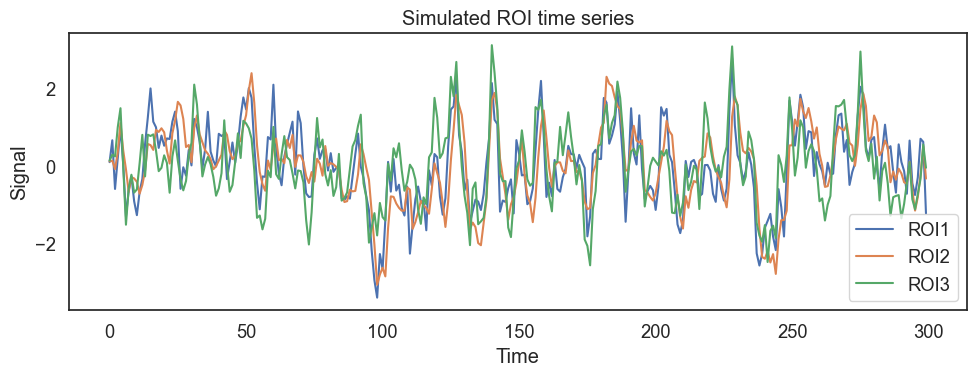

In [4]:
plt.figure(figsize=(10, 4))

for col in df.columns:
    plt.plot(df.index, df[col], label=col)

plt.title("Simulated ROI time series")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.legend()
plt.tight_layout()
plt.show()


---

## Correlation: What It Measures and Why We Compute It

Correlation is the simplest form of functional connectivity.  
It quantifies how strongly ROIs time series move together across time.

Key points:

- Correlation reflects **shared fluctuations**, regardless of where they come from.
- A high correlation does **not** imply a direct connection. It can arise from:
    - **Common drive:** two ROIs are pushed by the same global process.
    - **Indirect paths:** ROI1 influences ROI2 through ROI3.
    - **Chance alignment:** noise fluctuations line up over time.
- In this simulation, all ROIs are pushed by the same global drive, so correlation will tend to be broadly positive even if only one true directional link exists.

This step computes the correlation matrix and visualizes it to establish a baseline before moving to partial correlation, which removes indirect effects.


In [5]:
corr = df.corr()
corr

,ROI1,ROI2,ROI3
ROI1,1.000000,0.763964,0.712660
ROI2,0.763964,1.000000,0.633219
ROI3,0.712660,0.633219,1.000000


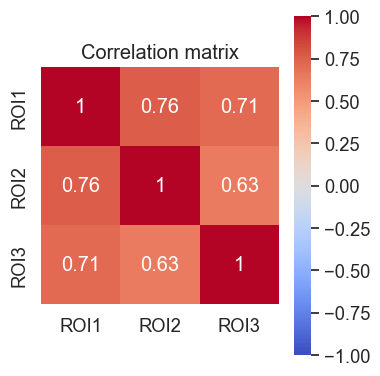

In [9]:
plt.figure(figsize=(4,4))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, square=True, cmap="coolwarm")
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()


### Interpreting the Correlation Matrix

The correlation matrix shows how strongly each pair of ROIs co-fluctuates over time.  
All off-diagonal values are high (0.63–0.76), which tells us something important about the way this dataset was generated.

- **All ROIs receive the same global driv**, so they rise and fall together even if they are not directly connected.
- **ROI1 and ROI2 show the strongest correlation**, because ROI2 is explicitly influenced by the previous value of ROI1 in the generative model.

Remember, in the model we have explicitly modeled direct influence

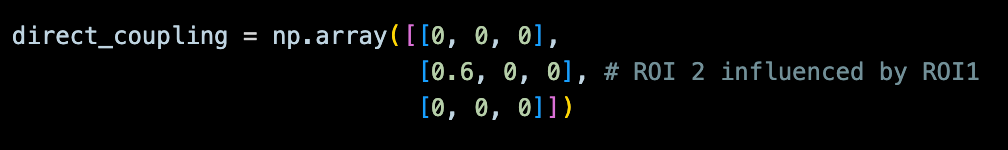

- **ROI1–ROI3 and ROI2–ROI3 remain strongly positive**, even though there is no direct connection involving ROI3. This is the effect of the shared global drive and the smooth AR(1) structure.
- **Correlation alone cannot separate direct from indirect effects**.  
  It only tells you that two signals behave similarly, not *why* they do.

This is why correlation is a useful first look but not sufficient for identifying direct functional relationships. The next step is partial correlation, which removes shared influences to reveal more specific structure.


## Partial Correlation

Partial correlation measures the relationship between two ROIs **after removing the influence of all other ROIs**.  
This is fundamentally different from plain correlation.

What this step does:

- It subtracts the shared global drive that made all ROIs look artificially similar.
- It removes indirect pathways (e.g., ROI1 → ROI2 → ROI3).
- It isolates the **unique** linear association between each pair of ROIs.

Expected outcome for this simulation:

- The strong correlation between ROI1 and ROI2 should remain, because there is a real directed link in the generative model.
- The apparent relationships involving ROI3 should shrink, because ROI3 had no direct connection; its correlations were driven by the shared global signal.
- The matrix will therefore be sparser and more informative than plain correlation.

This step exposes the specific functional structure hidden underneath shared and indirect effects.


In [13]:
from src.connectivity_analysis import analyse_partial_corr

partial = analyse_partial_corr(df.to_numpy())
partial_df = pd.DataFrame(partial, index=df.columns, columns=df.columns)
partial_df

,ROI1,ROI2,ROI3
ROI1,1.000000,0.575918,0.458346
ROI2,0.575918,1.000000,0.196113
ROI3,0.458346,0.196113,1.000000


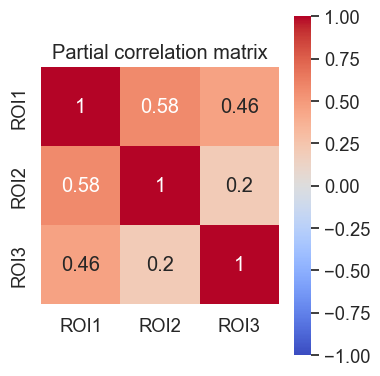

In [14]:
plt.figure(figsize=(4, 4))
sns.heatmap(
    partial_df,
    vmin=-1,
    vmax=1,
    annot=True,
    square=True,
    cmap="coolwarm",
)
plt.title("Partial correlation matrix")
plt.tight_layout()
plt.show()


### Interpreting the Partial Correlation Matrix

Partial correlation removes shared and indirect influences, leaving only the **unique** linear relationship between each pair of ROIs after controlling for the third one.

Here is what the values reveal in this simulation:

- **ROI1–ROI2 remains moderately strong (≈ 0.58).**  
  This reflects the real directed link we built into the generative model (ROI1 → ROI2).  
  Even after removing the global drive and the influence of ROI3, a substantial direct association remains.

- **ROI1–ROI3 drops from 0.71 (correlation) to ≈ 0.46.**  
  ROI1 and ROI3 had no direct connection.  
  Their high correlation was largely caused by the shared global drive.  
  Once that shared component is removed, only a smaller residual relationship remains.

- **ROI2–ROI3 drops even further (≈ 0.20).**  
  This pair had the weakest structural relationship.  
  After removing indirect effects and global input, very little remains.

The key point:  
Partial correlation exposes the **specific** connection structure (ROI1 → ROI2) hidden underneath the broad positive correlations created by the global drive.  
This demonstrates why partial correlation is more informative than raw correlation when common inputs or indirect paths are present.
